In [3]:
#| default_exp hedgerprep

In [4]:
#| export

import pandas as pd
import numpy as np
import matplotlib.pyplot as plot
from fastai.tabular.all import *


In [5]:
#| hide
import nbdev; nbdev.nbdev_export()

### Parameters

In [ ]:
data_dir = Path("./market")
save_dir = Path("./market/save")
market_open = "09:30"
rows_to_load = 1_500_000     # should be -1 for training, or positive smaller for faster testing
load_date = "20250103"

day_sample_count = 5000

In [ ]:
#| export
from pathlib import Path

# Define the directory and pattern
directory = Path("./market")
pattern = "*mbp-10*"

# Iterate over files matching the pattern
for file_path in directory.glob(pattern):
    print(file_path)

    # Extract the date from the file name
    date_str = file_path.name[10:18]
    print(f"Extracted date: {date_str}")

market/xnas-itch-20250103.mbp-10.csv
Extracted date: 20250103
market/xnas-itch-20250102.mbp-10.csv
Extracted date: 20250102


#### Load data

In [ ]:
#
if rows_to_load > 0:
    df = pd.read_csv(data_dir / f"xnas-itch-{load_date}.mbp-10.csv", nrows=rows_to_load)
else:
    df = pd.read_csv(data_dir / f"xnas-itch-{load_date}.mbp-10.csv")
#trddf = pd.read_csv(data_dir + f"xnas-itch-{load_date}.trades.csv", nrows=nrows)

df.head()

,ts_recv,ts_event,rtype,publisher_id,instrument_id,action,side,depth,price,size,...,ask_sz_08,bid_ct_08,ask_ct_08,bid_px_09,ask_px_09,bid_sz_09,ask_sz_09,bid_ct_09,ask_ct_09,symbol
0,2025-01-03T09:00:00.015869440Z,2025-01-03T09:00:00.015702539Z,10,2,11667,A,N,0,140.97,100,...,0,0,0,NaN,NaN,0,0,0,0,NVDA
1,2025-01-03T09:00:00.015938794Z,2025-01-03T09:00:00.015771793Z,10,2,11667,A,B,0,137.50,10000,...,0,0,0,NaN,NaN,0,0,0,0,NVDA
2,2025-01-03T09:00:00.040850395Z,2025-01-03T09:00:00.040665733Z,10,2,11667,A,A,1,157.05,73,...,0,0,0,NaN,NaN,0,0,0,0,NVDA
3,2025-01-03T09:00:00.059865276Z,2025-01-03T09:00:00.059698561Z,10,2,11667,A,A,0,138.81,1000,...,0,0,0,NaN,NaN,0,0,0,0,NVDA
4,2025-01-03T09:00:00.085513156Z,2025-01-03T09:00:00.085346759Z,10,2,11667,A,B,1,121.00,20,...,0,0,0,NaN,NaN,0,0,0,0,NVDA


In [34]:
df.shape

(1500000, 74)

#### Adjust timestamps + drop outside market hours

In [35]:
df["ts_event"] = pd.to_datetime(df.ts_event, unit="ns")
df["ts_event"] = df["ts_event"].dt.tz_convert('US/Eastern')
df = df[df["ts_event"].dt.time >= pd.to_datetime("09:30").time()]
df = df[df["ts_event"].dt.time <= pd.to_datetime("16:00").time()]
#df.set_index('ts_event', inplace=True)

market_open = pd.to_datetime("09:30").time()
print(market_open)
df['ns_since_open'] = (df['ts_event'] - df['ts_event'].dt.normalize() - pd.to_timedelta(market_open.hour, unit='h') - pd.to_timedelta(market_open.minute, unit='m')).dt.total_seconds() * 1e9 + df['ts_event'].dt.nanosecond

df = add_datepart(df, 'ts_event', drop=False)

' '.join(o for o in df.columns if o.startswith('ts_event'))


09:30:00


'ts_event ts_eventYear ts_eventMonth ts_eventWeek ts_eventDay ts_eventDayofweek ts_eventDayofyear ts_eventIs_month_end ts_eventIs_month_start ts_eventIs_quarter_end ts_eventIs_quarter_start ts_eventIs_year_end ts_eventIs_year_start ts_eventElapsed'

#### Cleanup (drop rows with NA)

In [36]:
orig_len = df.shape[0]
df.dropna(inplace=True)
cur_len = df.shape[0]
drop_cnt = orig_len-cur_len
if  drop_cnt > 1000:
    raise Exception(f"{drop_cnt} rows dropped, seems a lot")
else:
    print(f"{drop_cnt} dropped out of {orig_len}")

0 dropped out of 1419224


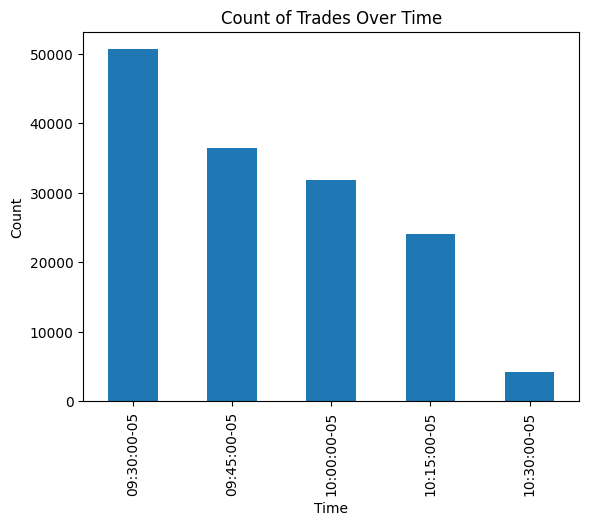

In [37]:
# Filter the dataframe for action "T"
df_trades = df[df['action'] == "T"]

# Group by buckets of 15 minutes
df_trades.set_index('ts_event').resample('15min').size().plot(kind='bar', title='Count of Trades Over Time')
plot.xlabel('Time')
#plot.xticks(rotation=45)
labels = [item.get_text().split(' ')[1].split('+')[0][:-3] for item in plot.gca().get_xticklabels()]
plot.gca().set_xticklabels(labels)
plot.ylabel('Count')
plot.show()

In [38]:
trades = df[(df.action == "T") & (df.side != "N")]
cols = ["action", "side", "price", "size", "bid_sz_00", "bid_px_00", "ask_px_00", "ask_sz_00",
         "bid_sz_01", "bid_px_01", "ask_px_01", "ask_sz_01","sequence"]
trades.side.value_counts()


side
B    68613
A    48104
Name: count, dtype: int64

In [39]:
def display_around(idx, nbrows=6):
    iloc_index = df.index.get_loc(idx)
    print(iloc_index)
    return df.iloc[iloc_index-1:iloc_index+nbrows-1][cols]
idx = 0

In [40]:
x = display_around(trades.index[idx])
print(idx, trades.index[idx])
idx = idx + 1
x

1
0 80777


,action,side,price,size,bid_sz_00,bid_px_00,ask_px_00,ask_sz_00,bid_sz_01,bid_px_01,ask_px_01,ask_sz_01,sequence
80776,T,N,140.03,1,1479,140.0,140.05,50,50,139.96,140.06,4017,21892058
80777,T,A,140.00,259,1479,140.0,140.05,50,50,139.96,140.06,4017,21892059
80778,C,B,140.00,259,1220,140.0,140.05,50,50,139.96,140.06,4017,21892059
80779,C,A,140.05,30,1220,140.0,140.05,20,50,139.96,140.06,4017,21892146
80780,C,B,139.91,400,1320,140.0,140.05,20,50,139.96,140.06,4017,21892148
80781,A,N,140.00,100,1420,140.0,140.05,50,50,139.96,140.06,4017,21893860


#### Add spread

<Axes: title={'center': 'Spread Over Time'}>

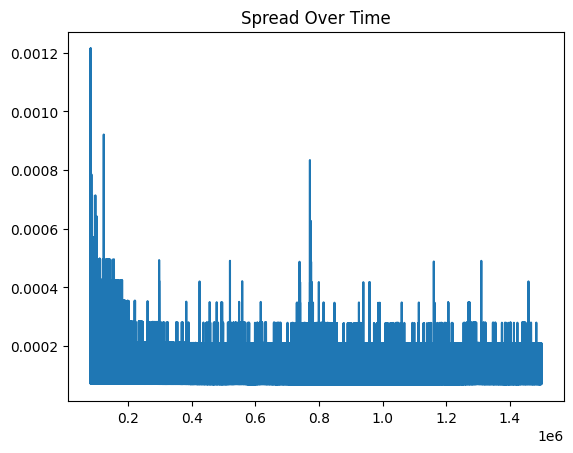

In [41]:
df['spread'] = (df['ask_px_00'] - df['bid_px_00'])/((df['bid_px_00']+df['ask_px_00'])/2)
df['spread'].plot(title='Spread Over Time')

### calculate imbalance

In [42]:
def calc_bid_weight(row):
    return  np.array([row['mid']/(row['mid']-row[f'bid_px_0{i}'])*row[f'bid_sz_0{i}'] for i in range(0,10)]).sum(axis=0)
def calc_ask_weight(row): 
    return np.array([row['mid']/(row[f'ask_px_0{i}']-row['mid'])*row[f'ask_sz_0{i}'] for i in range(0,10)]).sum(axis=0)    

In [43]:
# want to calculate the amount but also how spread out it is
df['mid'] = (df['bid_px_00']+df['ask_px_00'])/2
df['bid_weight'] = calc_bid_weight(df)
df['ask_weight'] = calc_ask_weight(df)
df['bid_weight_log'] = np.log(df['bid_weight'])
df['ask_weight_log'] = np.log(df['ask_weight'])

df[['bid_weight', 'ask_weight', 'bid_weight_log', 'ask_weight_log']].describe()

,bid_weight,ask_weight,bid_weight_log,ask_weight_log
count,1.419224e+06,1.419224e+06,1.419224e+06,1.419224e+06
mean,2.860703e+07,6.177271e+07,1.690730e+01,1.709416e+01
std,3.345243e+07,2.452760e+08,6.662027e-01,9.342870e-01
min,1.238872e+06,6.523670e+05,1.402971e+01,1.338836e+01
25%,1.516365e+07,1.533947e+07,1.653441e+01,1.654594e+01
50%,2.110311e+07,2.181425e+07,1.686493e+01,1.689807e+01
75%,3.117465e+07,3.739664e+07,1.725512e+01,1.743709e+01
max,1.335001e+09,1.012570e+10,2.101220e+01,2.303834e+01


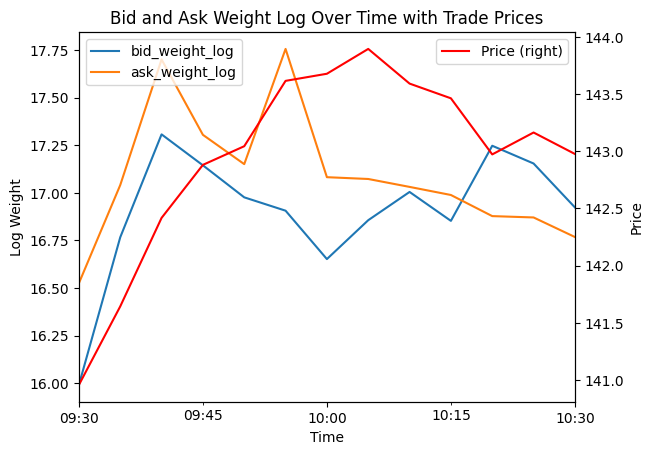

In [44]:

ax = df.set_index('ts_event')[['bid_weight_log', 'ask_weight_log']].resample('5min').mean().plot()
df[df['action'] == 'T'].set_index('ts_event')['price'].resample('5min').mean().plot(ax=ax, secondary_y=True, color='r', label='Price')
ax.set_xlabel('Time')
ax.set_ylabel('Log Weight')
ax.right_ax.set_ylabel('Price')
ax.set_title('Bid and Ask Weight Log Over Time with Trade Prices')
ax.legend(loc='upper left')
ax.right_ax.legend(loc='upper right')
plot.show()

### Calculating trades on the bid and ask side


In [45]:
# add a column with a the traded size by row, with 0 for non trade rows
# this makes the next calculation easier
df["traded_bid_size"] = df["size"] * ((df["action"] == "T") & (df["side"] == "B"))
df["traded_ask_size"] = df["size"] * ((df["action"] == "T") & (df["side"] == "A"))
df["is_trade_bid"] = ((df["action"] == "T") & (df["side"] == "B")) * 1
df["is_trade_ask"] = ((df["action"] == "T") & (df["side"] == "A")) * 1

def add_rolling_trades_cols(period):
    # temporary dataset so we can reindex
    x = df[['ts_event', 'traded_bid_size', 'traded_ask_size', 'is_trade_bid', 'is_trade_ask']].copy()
    x['original_index'] = df.index
    x.set_index("ts_event", inplace=True)

    # calculate
    x[f'rolling_{period}_bid_size'] = x["traded_bid_size"].rolling(period).sum()
    x[f'rolling_{period}_ask_size'] = x["traded_ask_size"].rolling(period).sum()
    x[f'rolling_{period}_bid_cnt'] = x["is_trade_bid"].rolling(period).sum()
    x[f'rolling_{period}_ask_cnt'] = x["is_trade_ask"].rolling(period).sum()

    # merge back to original dataframe
    x.set_index("original_index", inplace=True)
    df[f'rolling_{period}_bid_size'] = x[f'rolling_{period}_bid_size']
    df[f'rolling_{period}_ask_size'] = x[f'rolling_{period}_ask_size']
    df[f'rolling_{period}_bid_cnt'] = x[f'rolling_{period}_bid_cnt']
    df[f'rolling_{period}_ask_cnt'] = x[f'rolling_{period}_ask_cnt']


add_rolling_trades_cols('30s')
add_rolling_trades_cols('5min')

# and cleanup
_ = df.drop(columns=['traded_bid_size', 'traded_ask_size', 'is_trade_bid', 'is_trade_ask'])



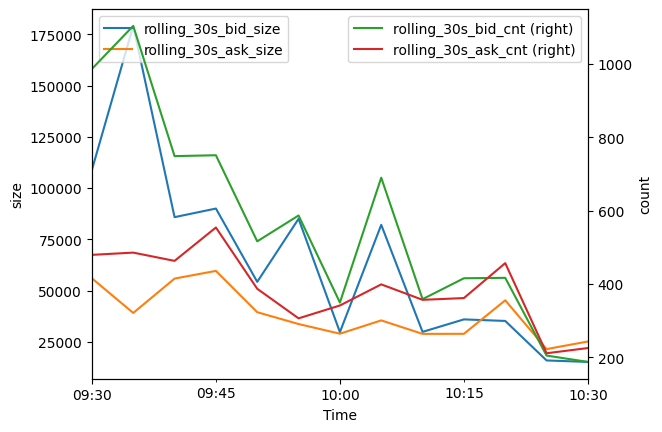

In [46]:
ax = df.set_index('ts_event')[['rolling_30s_bid_size', 'rolling_30s_ask_size']].resample('5min').mean().plot()
df.set_index('ts_event')[['rolling_30s_bid_cnt', 'rolling_30s_ask_cnt']].resample('5min').mean().plot(ax=ax, secondary_y=True)
ax.set_xlabel('Time')
ax.set_ylabel('size')
ax.right_ax.set_ylabel('count')
ax.legend(loc='upper left')
ax.right_ax.legend(loc='upper right')
plot.show()

### Identify the best hedge position for each row

In [47]:
rdf = df[df['action'] == 'A'].sample(n=day_sample_count)
#rdf['hedge_buy_exec_idx'] = rdf.apply(lambda row: df.index[(df.index > row.name) & (df['ask_px_00'] <= row['bid_px_00'])].min(), axis=1)
#rdf['hedge_sell_exec_idx'] = rdf.apply(lambda row: df.index[(df.index > row.name) & (df['bid_px_00'] >= row['ask_px_00'])].min(), axis=1)

rdf['hedge_buy_stop_idx'] = rdf.apply(lambda row: df.index[(df.index > row.name) & (df['bid_px_00'] >= row['bid_px_00']+0.02)].min(), axis=1)
rdf['hedge_sell_stop_idx'] = rdf.apply(lambda row: df.index[(df.index > row.name) & (df['ask_px_00'] <= row['ask_px_00']-0.02)].min(), axis=1)

rdf.shape

(5000, 108)

In [48]:
# fix NaN values
rdf['hedge_buy_stop_idx'] = rdf['hedge_buy_stop_idx'].where(~rdf['hedge_buy_stop_idx'].isna(), rdf.index)
rdf['hedge_sell_stop_idx'] = rdf['hedge_sell_stop_idx'].where(~rdf['hedge_sell_stop_idx'].isna(), rdf.index)

# convert idexes to int
rdf['hedge_buy_stop_idx'] = rdf['hedge_buy_stop_idx'].astype(int)
rdf['hedge_sell_stop_idx'] = rdf['hedge_sell_stop_idx'].astype(int)


def optimal_buy_price(row):
    idx = df.index.get_loc(row.name)
    return df.iloc[idx:idx+1+row['hedge_buy_stop_idx']]['ask_px_00'].min()

def optimal_sell_price(row):
    idx = df.index.get_loc(row.name)
    return df.iloc[idx:idx+1+row['hedge_sell_stop_idx']]['bid_px_00'].max()

# calculate ideal position between current point and stop loss point 
rdf['ideal_buy_price'] = rdf.apply(optimal_buy_price, axis=1)
rdf['ideal_sell_price'] = rdf.apply(optimal_sell_price, axis=1)

rdf['ideal_buy_price_spread'] = (rdf['ideal_buy_price'] - rdf['bid_px_00']) / (rdf['ask_px_00'] - rdf['bid_px_00'])
rdf['ideal_sell_price_spread'] = (rdf['ideal_sell_price'] - rdf['ask_px_00']) / (rdf['ask_px_00'] - rdf['bid_px_00'])



In [51]:
rdf[['ideal_buy_price_spread', 'ideal_buy_price', 'bid_px_00', 'ask_px_00']]
rdf[rdf.ideal_buy_price_spread>0][['ideal_buy_price_spread', 'ideal_buy_price', 'bid_px_00', 'ask_px_00']]

,ideal_buy_price_spread,ideal_buy_price,bid_px_00,ask_px_00
626069,0.50,142.55,142.54,142.56
279049,1.00,141.60,141.59,141.60
1499693,0.50,143.19,143.18,143.20
100099,0.25,140.25,140.24,140.28
633589,1.00,142.78,142.76,142.78
...,...,...,...,...
1492620,0.50,143.09,143.08,143.10
1303400,0.50,142.53,142.52,142.54
1303532,1.00,142.56,142.54,142.56
386285,1.00,142.33,142.32,142.33


<Axes: title={'center': 'Ideal Buy Price Spread'}, ylabel='Frequency'>

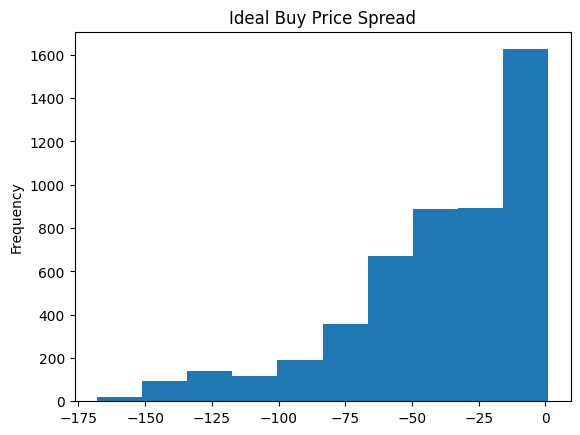

In [27]:
rdf['ideal_buy_price_spread'].plot(kind='hist', title='Ideal Buy Price Spread')

In [20]:
idx = 0

In [21]:
rdf.iloc[idx:idx+1][['bid_px_00', 'ask_px_00', 'ideal_buy_price', 'ideal_sell_price']]
stopidx = rdf.iloc[idx]['hedge_buy_stop_idx']
row = rdf.iloc[idx]
rowiloc = df.index.get_loc(row.name)
stopiloc = df.index.get_loc(stopidx)
print(row[['bid_px_00', 'ask_px_00', 'ideal_buy_price', 'ideal_sell_price']])
df.iloc[rowiloc:stopiloc][['bid_px_00', 'ask_px_00']]

bid_px_00            142.9
ask_px_00           142.91
ideal_buy_price     142.86
ideal_sell_price    143.26
Name: 1480384, dtype: object


,bid_px_00,ask_px_00
1480384,142.90,142.91
1480385,142.90,142.91
1480386,142.90,142.91
1480387,142.90,142.91
1480388,142.90,142.91
...,...,...
1481783,142.92,142.94
1481784,142.92,142.94
1481785,142.92,142.94
1481786,142.92,142.94


In [22]:
row = df.loc[1459267]
df.index[(df.index > row.name) & (df['ask_px_00'] <= row['bid_px_00'])].min()
row.ask_px_00, df.loc[row.name:].ask_px_00.min()

(np.float64(142.8), np.float64(142.8))

#### Isolate buy and sell into 2 rows

In [54]:
rdf_buy = rdf.copy()
rdf_buy['is_buy'] = True
rdf_buy['ideal_price'] = rdf_buy['ideal_buy_price']
rdf_buy['ideal_price_spread'] = rdf_buy['ideal_buy_price_spread']
rdf_buy.drop(columns=['ideal_buy_price'], inplace=True)

rdf_sell = rdf.copy()
rdf_sell['is_buy'] = False
rdf_sell['ideal_price'] = rdf_sell['ideal_sell_price']
rdf_sell['ideal_price_spread'] = rdf_buy['ideal_sell_price_spread']
rdf_sell.drop(columns=['ideal_sell_price'], inplace=True)

rdf_combined = pd.concat([rdf_buy, rdf_sell])
rdf_combined[['is_buy','ideal_price']].info()


<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 1406159 to 254845
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   is_buy       10000 non-null  bool   
 1   ideal_price  10000 non-null  float64
dtypes: bool(1), float64(1)
memory usage: 166.0 KB


#### cleanup columns

In [55]:
for i in range(0, 10):
    rdf_combined.drop(columns=[f'bid_px_0{i}', f'ask_px_0{i}'], inplace=True)
    rdf_combined.drop(columns=[f'bid_sz_0{i}', f'ask_sz_0{i}'], inplace=True)
    rdf_combined.drop(columns=[f'bid_ct_0{i}', f'ask_ct_0{i}'], inplace=True)



#### Save result

In [56]:
os.makedirs(save_dir, exist_ok=True)
rdf_combined.to_csv(save_dir / 'rdf_output.csv', index=False)

### search of one order triggering more than one execution

### search of iceberg orders

### Consider latency